# Pytorch-预训练ImageNet图像分类可解释性分析

对Pytorch模型库中的ImageNet预训练图像分类模型进行可解释性分析。可视化指定预测类别的shap值热力图。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-10-24

## 导入工具包

In [1]:
import json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import shap

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入ImageNet预训练图像分类模型

In [2]:
model = torchvision.models.mobilenet_v2(pretrained=True, progress=False).eval().to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/featurize/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


## 载入ImageNet50数据集

In [3]:
X, y = shap.datasets.imagenet50()

In [4]:
X.shape

(50, 224, 224, 3)

## 载入ImageNet1000类别标注名称

下载链接：https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [5]:
with open('data/imagenet_class_index.json') as file:
    class_names = [v[1] for v in json.load(file).values()]

In [6]:
# class_names

## 载入一张测试图像

In [107]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/test/0818/test_%E7%9F%B3%E6%A6%B4.jpg

--2022-10-24 23:17:35--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/test/0818/test_%E7%9F%B3%E6%A6%B4.jpg
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 1326649 (1.3M) [image/jpeg]
正在保存至: “test_石榴.jpg”

test_石榴.jpg       100%[===================>]   1.26M  4.37MB/s    用时 0.3s    

2022-10-24 23:17:36 (4.37 MB/s) - 已保存 “test_石榴.jpg” [1326649/1326649])



In [7]:
img_path = 'test_img/test_草莓.jpg'

img_path = 'test_img/cat_dog.jpg'

In [8]:
img_pil = Image.open(img_path)

In [9]:
X = np.array(img_pil)

In [10]:
X.shape

(1560, 2340, 3)

In [11]:
X = torch.Tensor(X).unsqueeze(0)

In [12]:
X.shape

torch.Size([1, 1560, 2340, 3])

## 预处理

In [13]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

## 定义图像分类预测函数

In [14]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

## 测试整个工作流正常

In [16]:
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[0:3])
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [232]: ['Border_collie']


## 设置shap可解释性分析算法

In [106]:
batch_size = 50
n_evals = 20000

# 定义 mask，用于遮盖输入图像上的局部
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

## 指定单个预测类别

In [88]:
# 281：虎斑猫 tabby
shap_values = explainer(Xtr[0].unsqueeze(0), max_evals=n_evals, batch_size=batch_size, outputs=[281])

  0%|          | 0/19998 [00:00<?, ?it/s]

Partition explainer: 2it [01:06, 66.90s/it]               


In [90]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


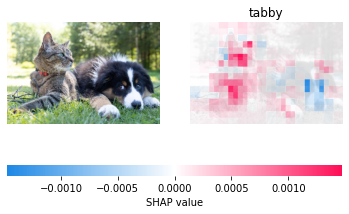

In [96]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 指定多个预测类别

In [107]:
# 232 边牧犬 border collie
# 281：虎斑猫 tabby
# 852 网球 tennis ball
shap_values = explainer(Xtr[0].unsqueeze(0), max_evals=n_evals, batch_size=batch_size, outputs=[232, 281, 852])

  0%|          | 0/19998 [00:00<?, ?it/s]

Partition explainer: 2it [01:10, 70.83s/it]               


In [108]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


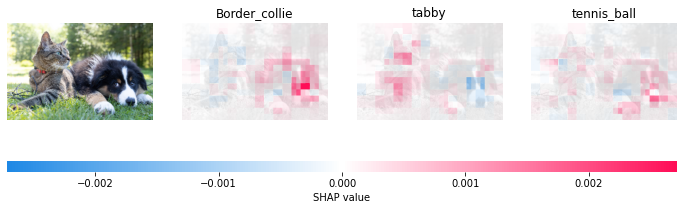

In [109]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 前topk预测类别

In [123]:
topk = 5

In [124]:
shap_values = explainer(Xtr[0].unsqueeze(0), max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/19998 [00:00<?, ?it/s]

Partition explainer: 2it [01:08, 68.37s/it]               


In [125]:
# 输入图像的每个像素，对于 topk 个类别的 shap 值
shap_values.shape

(1, 224, 336, 3, 5)

In [126]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # 各个类别的shap值热力图

In [131]:
# 原图
shap_values.data.shape

(224, 336, 3)

In [128]:
# 各个类别的shap值热力图
len(shap_values.values)

5

In [132]:
# 第一个类别，shap值热力图
shap_values.values[0].shape

(224, 336, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


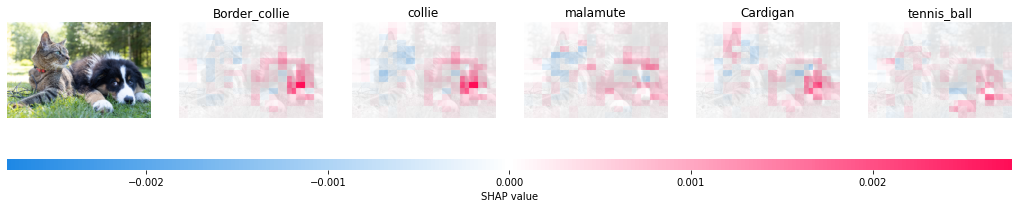

In [134]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names
                )